In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

#  Load and sort the data
df = pd.read_csv('/Users/danghoanganhquan/Desktop/Machine Learning/project/Ultimate_Completed_Featured_tennis_data.csv')  # Replace with your dataset file path
df['tourney_date'] = pd.to_datetime(df['tourney_date'])  # Ensure date column is in datetime format
df = df.sort_values(by='tourney_date')  # Sort data chronologically

# Calculate the age difference
df['age_diff'] = df['winner_age'] - df['loser_age']

# Feature selection
features = [
    'surface_elo_diff', 'rank_points_diff',
    '1stServeWonPct_diff_last1', '2ndServeWonPct_diff_last1',
    '1stServeWonPct_diff_last3', '2ndServeWonPct_diff_last3',
    '1stServeWonPct_diff_last5', '2ndServeWonPct_diff_last5',
    'bpSavedPct_diff_last1', 'bpPerSvcPt_diff_last1',
    'bpSavedPct_diff_last3', 'bpPerSvcPt_diff_last3',
    'bpSavedPct_diff_last5', 'bpPerSvcPt_diff_last5',
    'acePct_diff_last1', 'dfPct_diff_last1',
    'acePct_diff_last3', 'dfPct_diff_last3',
    'acePct_diff_last5', 'dfPct_diff_last5',
    'rank_diff', 'h2h_diff', 'h2h_surface_diff',
    'win_diff_last5', 'win_diff_last10', 'win_diff_last20',
    'top10_win_diff_last5', 'top10_win_diff_last10',
    'top20_win_diff_last5', 'top20_win_diff_last10',
    'surface_elo_avg_change_diff_last3', 'surface_elo_avg_change_diff_last5', 'surface_elo_avg_change_diff_last10',
    'age_diff',  # New age_diff feature
    'hrs_diff_prev1', 'hrs_diff_prev2'
]

X = df[features]  # Features
y = df['is_player1_winner'].astype(int)  # Convert True/False to 1/0

# Step 3: Dropping rows with missing values in both features and target
df_cleaned = df.dropna(subset=features + ['is_player1_winner'])  # Drop rows where any of the features or target is NaN
X_cleaned = df_cleaned[features]  # Features
y_cleaned = df_cleaned['is_player1_winner'].astype(int)  # Target (1 for win, 0 for loss)

# Time-based train/val/test splits
def time_split(df, date_col, train_end='2018-12-31', val_end='2021-12-31'):
    train = df[df[date_col] <= train_end]
    val = df[(df[date_col] > train_end) & (df[date_col] <= val_end)]
    test = df[df[date_col] > val_end]
    return train, val, test

train, val, test = time_split(df_cleaned, 'tourney_date')

# Split features/target
X_train, y_train = train[features], train['is_player1_winner'].astype(int)
X_val, y_val = val[features], val['is_player1_winner'].astype(int)
X_test, y_test = test[features], test['is_player1_winner'].astype(int)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## **Logistic Regression**

### **Approach 1**

In [50]:
# Train the logistic regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)

# Make predictions and evaluate the model
y_pred = logreg.predict(X_test_scaled)

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, logreg.predict_proba(X_test_scaled)[:, 1])
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("ROC AUC:", roc_auc)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 0.6566198901769371
ROC AUC: 0.7207630586679533
Confusion Matrix:
 [[2701 1354]
 [1460 2680]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.67      0.66      4055
           1       0.66      0.65      0.66      4140

    accuracy                           0.66      8195
   macro avg       0.66      0.66      0.66      8195
weighted avg       0.66      0.66      0.66      8195



### **Approach 2**

=== Best Model ===
Regularization (C): 0.01
Validation AUC: 0.7085
Test Accuracy: 0.6563
Test AUC: 0.7208



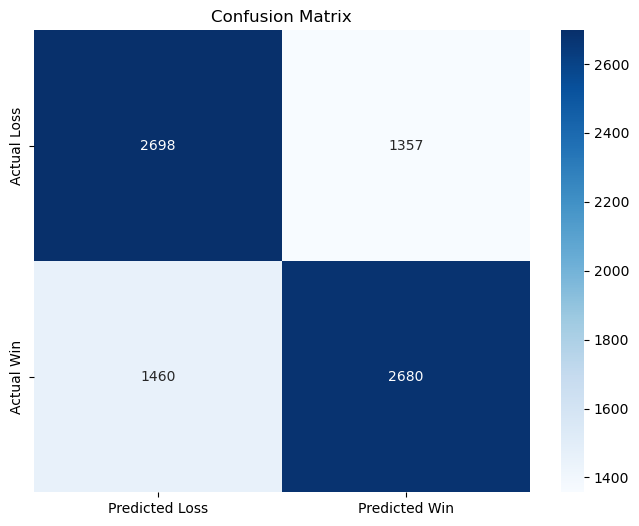

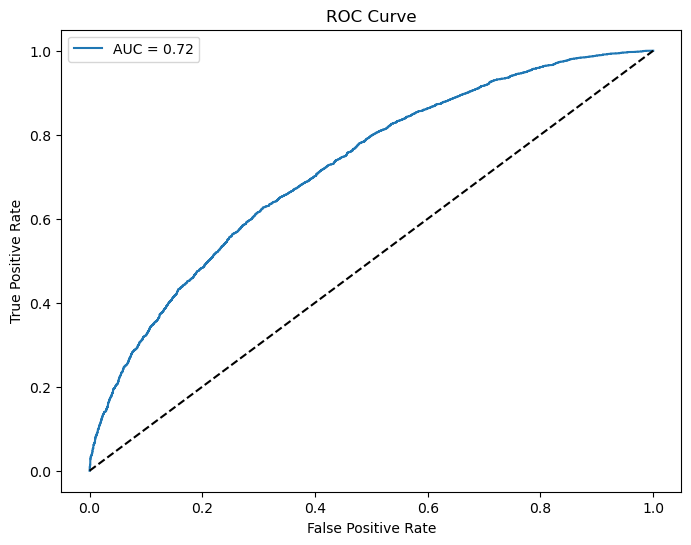

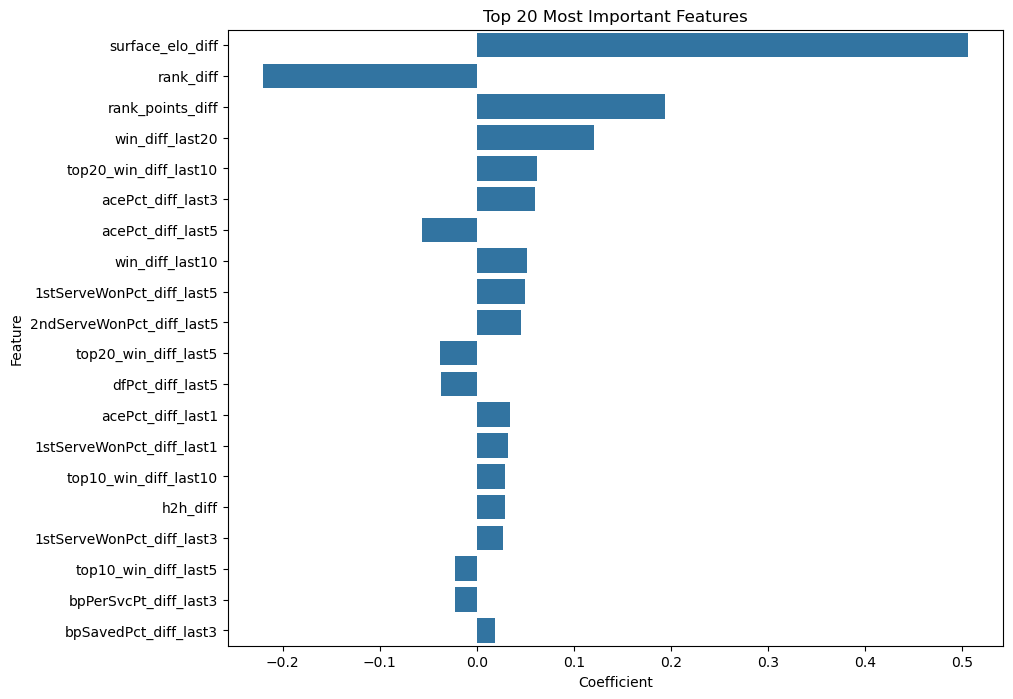

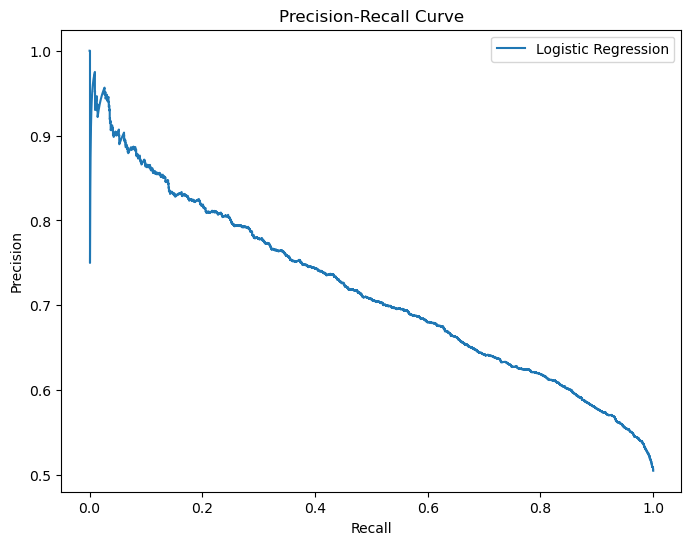

              precision    recall  f1-score   support

           0       0.65      0.67      0.66      4055
           1       0.66      0.65      0.66      4140

    accuracy                           0.66      8195
   macro avg       0.66      0.66      0.66      8195
weighted avg       0.66      0.66      0.66      8195



In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, roc_auc_score, confusion_matrix, classification_report,roc_curve, precision_recall_curve)
from sklearn.model_selection import TimeSeriesSplit

# Logistic Regression with hyperparameter tuning
best_score = 0
best_model = None
results = []

# Test different regularization strengths
for C in [0.001, 0.01, 0.1, 1, 10, 100]:
    model = LogisticRegression(C=C, max_iter=1000, random_state=42)
    model.fit(X_train_scaled, y_train)
    
    # Validate on validation set
    val_pred = model.predict_proba(X_val_scaled)[:, 1]
    val_auc = roc_auc_score(y_val, val_pred)
    results.append({'C': C, 'AUC': val_auc})
    
    if val_auc > best_score:
        best_score = val_auc
        best_model = model

# Evaluate best model
test_pred = best_model.predict(X_test_scaled)
test_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Metrics
print("=== Best Model ===")
print(f"Regularization (C): {best_model.C}")
print(f"Validation AUC: {best_score:.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, test_pred):.4f}")
print(f"Test AUC: {roc_auc_score(y_test, test_proba):.4f}\n")

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, test_pred), 
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Loss', 'Predicted Win'],
            yticklabels=['Actual Loss', 'Actual Win'])
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, test_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, test_proba):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Feature Importance
importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': best_model.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=importance.head(20))
plt.title('Top 20 Most Important Features')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, test_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Print classification report
print(classification_report(y_test, test_pred))


## **Artifical Neural Network**

### **Approach 1**

Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6024 - loss: 0.6765 - val_accuracy: 0.6584 - val_loss: 0.6100
Epoch 2/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - accuracy: 0.6611 - loss: 0.6132 - val_accuracy: 0.6698 - val_loss: 0.5978
Epoch 3/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - accuracy: 0.6759 - loss: 0.5969 - val_accuracy: 0.6794 - val_loss: 0.5882
Epoch 4/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - accuracy: 0.6796 - loss: 0.5920 - val_accuracy: 0.6855 - val_loss: 0.5820
Epoch 5/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - accuracy: 0.6856 - loss: 0.5847 - val_accuracy: 0.6921 - val_loss: 0.5766
Epoch 6/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - accuracy: 0.6857 - loss: 0.5843 - val_accuracy: 0.6926 - val_loss: 0.5722
Epoch 7/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - accuracy: 0.6909 - loss: 0.5785 - val_accuracy: 0.6987 - val_loss: 0.5690
Epoch 8/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - accuracy: 0.6954 - loss: 0.5748 - val_ac

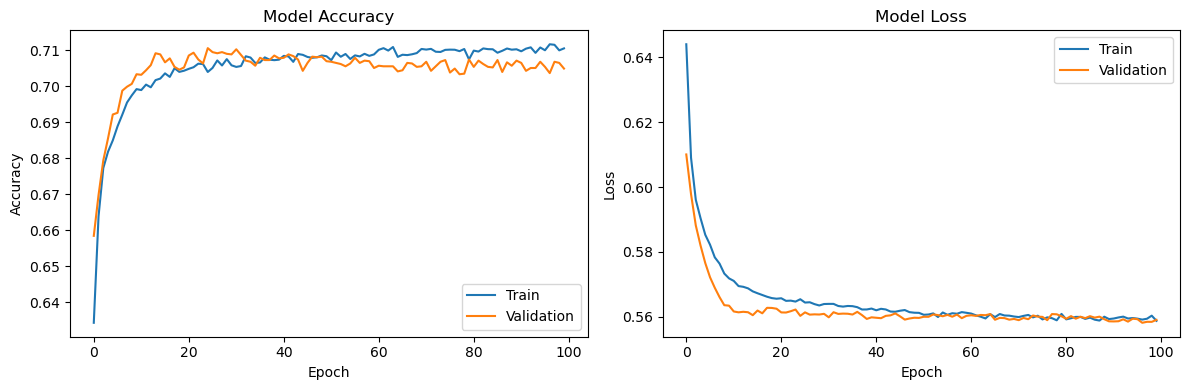

<bound method Model.summary of <Sequential name=sequential_1, built=True>>

In [6]:
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

# Define the model architecture
model = Sequential([
    Dense(128, input_shape=(X_train_scaled.shape[1],), activation='relu'),
    Dropout(0.45),
    Dense(1, activation='sigmoid')  # Output layer with sigmoid for binary classification
])

# Compile the model
optimizer = Adam(learning_rate=0.00045)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=256,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stop],
    verbose=1
)

# Make predictions
y_pred_prob = model.predict(X_test_scaled).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Neural Network Accuracy:", accuracy)
print("ROC AUC:", roc_auc)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

model.summary

### **Approach 2**

Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.6905 - binary_accuracy: 0.6367 - loss: 0.6354 - val_auc: 0.7381 - val_binary_accuracy: 0.6649 - val_loss: 0.5956
Epoch 2/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7457 - binary_accuracy: 0.6790 - loss: 0.5951 - val_auc: 0.7604 - val_binary_accuracy: 0.6916 - val_loss: 0.5783
Epoch 3/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7599 - binary_accuracy: 0.6899 - loss: 0.5816 - val_auc: 0.7711 - val_binary_accuracy: 0.6976 - val_loss: 0.5689
Epoch 4/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7673 - binary_accuracy: 0.6966 - loss: 0.5758 - val_auc: 0.7784 - val_binary_accuracy: 0.7011 - val_loss: 0.5624
Epoch 5/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7699 - binary_accuracy: 0.6991 - loss: 0.5726 - val_auc: 0.7809 - val_binary_accuracy: 0.7033 - val_loss: 0.5613
Epoch 6/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7715 - binary_accuracy: 0.7001 - loss: 0.5717 - val_auc: 0.7810 - val_binar

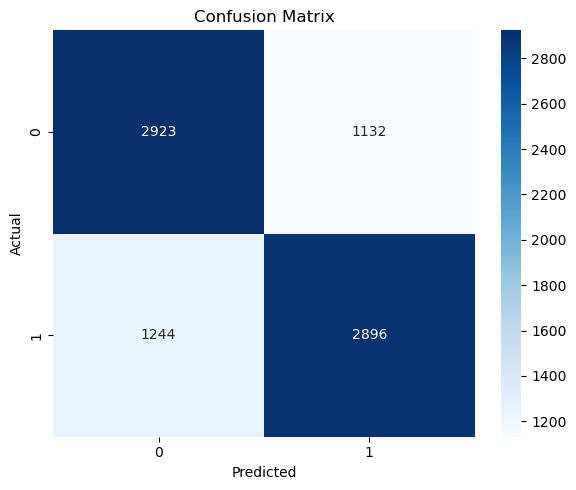

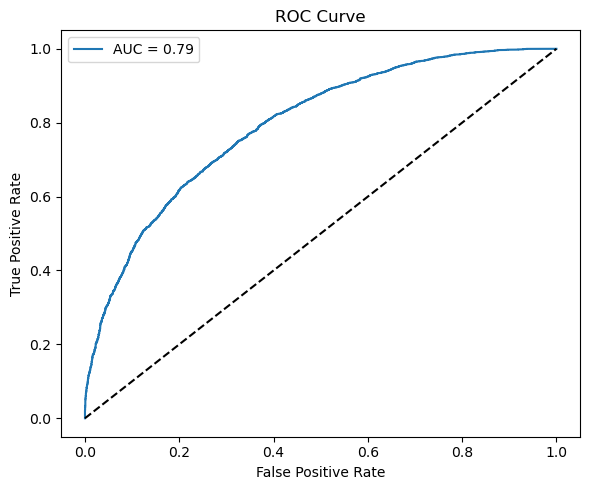

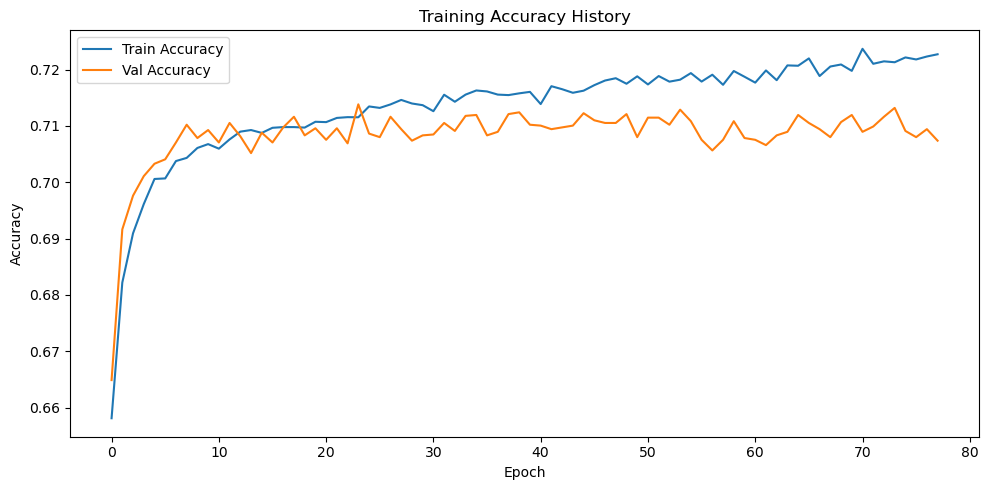

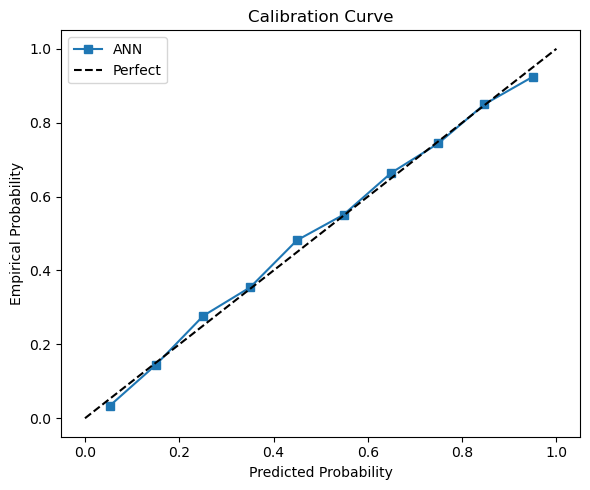

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#  Model definition
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['binary_accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Train with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=256,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stop],
    verbose=1
)

#  Evaluation
test_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
test_proba = model.predict(X_test_scaled)
test_acc = accuracy_score(y_test, test_pred)
test_auc = roc_auc_score(y_test, test_proba)

print("=== Neural Network Results ===")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}\n")
print(classification_report(y_test, test_pred))

#  Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, test_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, test_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {test_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.tight_layout()
plt.show()

#  Training history
plt.figure(figsize=(10, 5))
if 'binary_accuracy' in history.history:
    plt.plot(history.history['binary_accuracy'], label='Train Accuracy')
if 'val_binary_accuracy' in history.history:
    plt.plot(history.history['val_binary_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy History')
plt.legend()
plt.tight_layout()
plt.show()

#  Calibration Curve
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, test_proba.flatten(), n_bins=10)

plt.figure(figsize=(6, 5))
plt.plot(prob_pred, prob_true, 's-', label='ANN')
plt.plot([0, 1], [0, 1], 'k--', label='Perfect')
plt.xlabel('Predicted Probability')
plt.ylabel('Empirical Probability')
plt.title('Calibration Curve')
plt.legend()
plt.tight_layout()
plt.show()


### **Defining optimal hidden layers**

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from kerastuner import HyperModel, RandomSearch

class ANNHyperModel(HyperModel):
    def __init__(self, input_dim):
        self.input_dim = input_dim

    def build(self, hp):
        model = Sequential()
        # Add Input layer explicitly
        model.add(Input(shape=(self.input_dim,)))
        
        # First hidden layer
        model.add(Dense(
            units=hp.Int('units_input', min_value=64, max_value=512, step=64),
            activation='relu'
        ))
        model.add(Dropout(
            rate=hp.Float('dropout_input', min_value=0.2, max_value=0.5, step=0.1)
        ))

        # Additional hidden layers
        for i in range(hp.Int('num_layers', 1, 5)):
            model.add(Dense(
                units=hp.Int(f'units_{i}', min_value=64, max_value=512, step=64),
                activation='relu'
            ))
            model.add(Dropout(
                rate=hp.Float(f'dropout_{i}', min_value=0.2, max_value=0.5, step=0.1)
            ))

        # Output layer
        model.add(Dense(1, activation='sigmoid'))
        
        # Compile model
        model.compile(
            optimizer=Adam(
                hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])
            ),
            loss='binary_crossentropy',
            metrics=['accuracy', AUC(name='auc')]
        )
        return model

# Initialize tuner
tuner = RandomSearch(
    ANNHyperModel(input_dim=X_train_scaled.shape[1]),
    objective='val_auc',
    max_trials=10,
    executions_per_trial=2,  # Increased for more reliable results
    directory='ann_tuning',
    project_name='tennis_nn',
    overwrite=True  # Add this to prevent reloading issues
)

# Perform search
tuner.search(
    X_train_scaled, 
    y_train, 
    validation_data=(X_val_scaled, y_val), 
    epochs=30, 
    batch_size=256,
    verbose=1
)

# Get best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Trial 10 Complete [00h 01m 26s]
val_auc: 0.790478527545929

Best val_auc So Far: 0.7939826548099518
Total elapsed time: 00h 13m 05s


/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 320)            │        82,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           321 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,033 (359.50 KB)

 Trainable params: 92,033 (359.50 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
tuner.results_summary()

Results summary
Results in ann_tuning/tennis_nn
Showing 10 best trials
Objective(name="val_auc", direction="max")

Trial 05 summary
Hyperparameters:
units_input: 256
dropout_input: 0.4
num_layers: 1
units_0: 320
dropout_0: 0.2
learning_rate: 0.001
units_1: 320
dropout_1: 0.4
units_2: 448
dropout_2: 0.30000000000000004
units_3: 256
dropout_3: 0.4
units_4: 320
dropout_4: 0.2
Score: 0.7939826548099518

Trial 01 summary
Hyperparameters:
units_input: 256
dropout_input: 0.2
num_layers: 1
units_0: 448
dropout_0: 0.4
learning_rate: 0.001
units_1: 384
dropout_1: 0.30000000000000004
units_2: 192
dropout_2: 0.4
units_3: 128
dropout_3: 0.30000000000000004
Score: 0.7917745411396027

Trial 03 summary
Hyperparameters:
units_input: 192
dropout_input: 0.30000000000000004
num_layers: 1
units_0: 448
dropout_0: 0.4
learning_rate: 0.001
units_1: 256
dropout_1: 0.30000000000000004
units_2: 384
dropout_2: 0.30000000000000004
units_3: 512
dropout_3: 0.30000000000000004
units_4: 64
dropout_4: 0.4
Score: 0.7915

### **Approach 3**

Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.7209 - binary_accuracy: 0.6597 - loss: 0.6133 - val_auc: 0.7671 - val_binary_accuracy: 0.6949 - val_loss: 0.5723
Epoch 2/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.7598 - binary_accuracy: 0.6893 - loss: 0.5811 - val_auc: 0.7782 - val_binary_accuracy: 0.7014 - val_loss: 0.5620
Epoch 3/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.7675 - binary_accuracy: 0.6957 - loss: 0.5750 - val_auc: 0.7820 - val_binary_accuracy: 0.7042 - val_loss: 0.5617
Epoch 4/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.7745 - binary_accuracy: 0.7016 - loss: 0.5683 - val_auc: 0.7843 - val_binary_accuracy: 0.7074 - val_loss: 0.5579
Epoch 5/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.7775 - binary_accuracy: 0.7047 - loss: 0.5651 - val_auc: 0.7835 - val_binary_accuracy: 0.7096 - val_loss: 0.5594
Epoch 6/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.7795 - binary_accuracy: 0.7054 - loss: 0.5629 - val_auc: 0.7843 - val_binar

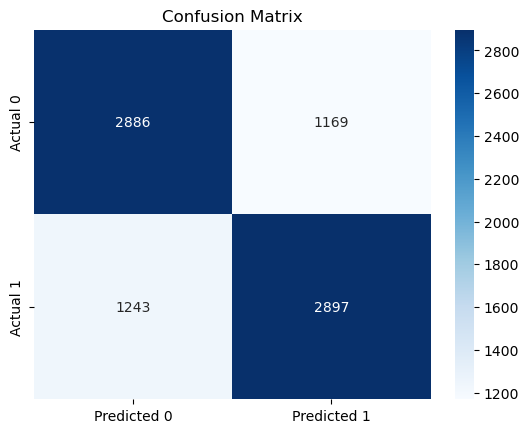

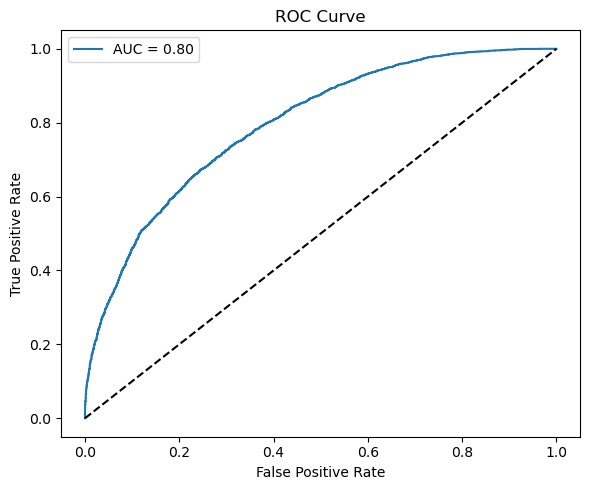

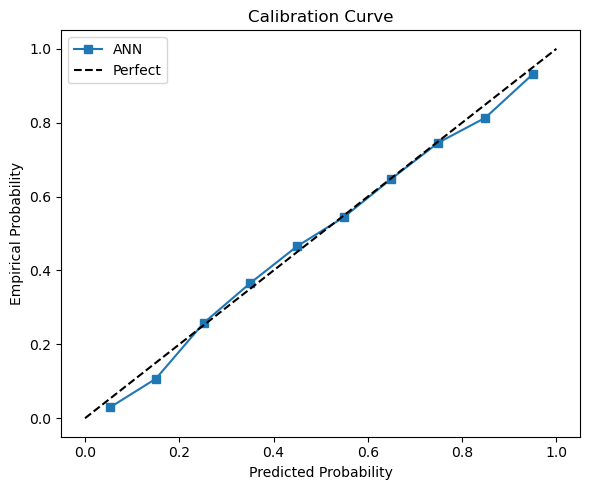

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.calibration import calibration_curve

#  Model definition
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dropout(0.4))
model.add(Dense(320, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['binary_accuracy', tf.keras.metrics.AUC(name='auc')]
)
# Train with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=256,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stop],
    verbose=1
)

# Evaluation
test_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
test_proba = model.predict(X_test_scaled)
test_acc = accuracy_score(y_test, test_pred)
test_auc = roc_auc_score(y_test, test_proba)
print("=== Neural Network Results ===")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}\n")
print(classification_report(y_test, test_pred))
# 9. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, test_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {test_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.tight_layout()
plt.show()

# Calibration Curve
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, test_proba.flatten(), n_bins=10)

plt.figure(figsize=(6, 5))
plt.plot(prob_pred, prob_true, 's-', label='ANN')
plt.plot([0, 1], [0, 1], 'k--', label='Perfect')
plt.xlabel('Predicted Probability')
plt.ylabel('Empirical Probability')
plt.title('Calibration Curve')
plt.legend()
plt.tight_layout()
plt.show()